In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Image Preprocessing

In [3]:
image = Image.open("./assets/styles/composition-VII.jpeg")

composed_transformation = transforms.Compose([
    # 224 is the input size for VGG (later)
    transforms.Resize( (224, 224) ),
    transforms.ToTensor()
])

In [4]:
def preprocess_image(image: Image) -> torch.Tensor:
    """
    Given a PIL image, resizes it and converts it to a torch tensor

    Args:
        image (Image): PIL image

    Returns:
        Tensor of dim (#channels, height, width)
    """
    composed_image: torch.Tensor = composed_transformation(image)

    return composed_image

(-0.5, 223.5, 223.5, -0.5)

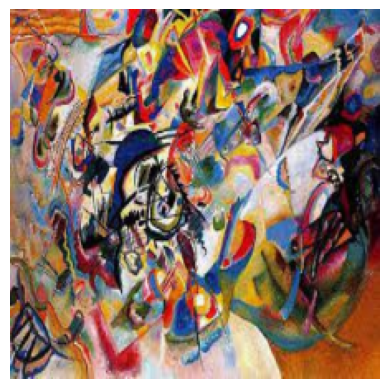

In [5]:
proccessed_image = preprocess_image(image)

# Adjust image dim to be compatible with plt
# (#c, h, w) -> (h, w, #c) 
plt.imshow(proccessed_image.permute(1, 2, 0))
plt.axis('off')

#### CNN model (VGG)

In [6]:
vgg_model = torchvision.models.vgg19_bn(weights=torchvision.models.VGG19_BN_Weights).to(device)

/cs/student/ug/2022/haojiepe/Documents/style-transfer/.venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Extract the convolutional layers
conv_layers = []

for layer in vgg_model.features:
    if isinstance(layer, torch.nn.Conv2d):
        conv_layers.append(layer)

    layer.requires_grad_(False)

len(conv_layers)

16

#### Content Loss Function
We can define the **feature map** of an image by $F^l_{ij}$ with $i$ and $j$ denoting the $i^{th}$ filter at position $j$ in layer $l$.

* In particular, the loss function is defined by the MSE between 
    - the feature map of the original image, $\vec{p}$, denoted by $P^l$ and 
    - the feature map of the generated image, $\vec{x}$, denoted by $F^l$

$$\mathcal{L}(\vec{p},\:\vec{x},\:l)=\frac{1}{2}\sum_{i,\:j}(F^l_{ij} -P^l_{ij})^2$$

In [8]:
# Stores (layer_name, image): feature_map
features = {}

In [9]:
def get_feature_map(image: torch.Tensor, layer: torch.nn.Conv2d, cache: bool = False) -> torch.Tensor:
    """
    Given an image and a convolutional layer, returns the feature map
    of the image after passing through the layer

    Done using Pytorch hooks:
    https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks

    Args:
        image (Tensor): Image of dim (#channels, height, width)
        layer (torch.nn.Conv2d): Convolutional layer

    Returns:
        Tensor of dim (#channels, height, width)
    """
    # Return cached value if already computed
    if (layer, image) in features:
        return features[(layer, image)]
    
    activation = None
    
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output

    hook = layer.register_forward_hook(hook_fn)

    # Add a dimension to the image to make it (1, height, width, #channels)
    image = image.unsqueeze(0)#.to(device)
    vgg_model(image)

    hook.remove()

    if cache:
        features[(layer, image)] = activation

    if image.requires_grad:
        activation.requires_grad_(True)

    return activation.squeeze(0)

In [10]:
def get_content_loss(
    content_image: torch.Tensor,
    generated_image: torch.Tensor,
    layer: torch.nn.Conv2d
) -> torch.Tensor:
    """
    Computes the content loss

    Args:
        content_image (Tensor): Content image
        generated_image (Tensor): Generated image
        layer (torch.nn.Conv2d): Convolutional layer

    Returns:
        Tensor: Content loss
    """
    P_l = get_feature_map(content_image, layer, cache=True)
    F_l = get_feature_map(generated_image, layer)

    assert P_l.shape == F_l.shape, "Feature maps must have the same shape"
    
    mse = torch.nn.MSELoss()
    content_loss = mse(P_l, F_l)
    return content_loss

The derative of said loss function is hence the following:

$\begin{equation}
\frac{\partial \mathcal{L}_{content}}{\partial F^{\:l}_{ij}}=
    \begin{cases}
        (F^{\:l}-P^{\:l})_{ij} & \text{if } F^{\:l}_{ij} > 0\\
        0 & \text{if } F^{\:l}_{ij} < 0
    \end{cases}
\end{equation}$

which can be expressed as $max(0,\:(F^l-P^l)_{ij})$ but will be omitted thanks to Pytorch's autograd

---

#### Style Loss Function

In the paper, the style representation is computed by the **correlation** between the different filter responses.

The correlation is given by a modified binary Gram matrix, $G^l$, which is the inner product of the feature maps $i$ and $j$ in the layer.

$$G^{\:l}_{ij}=\sum_k F^{\:l}_{ik}F^{\:l}_{jk}$$

To generate the texture that emulates the image, we start from a *white noise* (random) image and gradient descent

We want to minismize the MSE of the gram matrix of the original ($A^{\:l}_{ij}$) and generated image ($G^{\:l}_{ij}$)

$$E_l=\frac{1}{(2N_lM_l)^2}\sum_{i,j}(G^{\:l}_{ij}-A^{\:l}_{ij})^2$$

*Note the coefficient of the summation is for normalization*

##### Loss Fn

$$\mathcal{L}_{style}(\vec{a},\:\vec{x})=\sum_{l=0}^Lw_lE_l$$


In [11]:
def get_gram_matrix(feature_map: torch.Tensor) -> torch.Tensor:
    """
    Computes the gram matrix of a feature map, given two filter indices

    Args:
        feature_map (Tensor): Feature map of dim (#channels, height, width)

    Returns:
        Tensor: Gram matrix of dim (#channels, #channels)
    """
    n_channels = feature_map.shape[0]
    feature_map = feature_map.reshape(n_channels, -1)

    gram_matrix = torch.matmul(feature_map, feature_map.T)
    assert gram_matrix.shape == (n_channels, n_channels)

    return gram_matrix

In [12]:
def get_style_loss_of_layer(
    A_l: torch.Tensor,
    G_l: torch.Tensor,
) -> float:
    """
    Computes the style loss of a layer

    Args:
        A_l (Tensor): Style image feature map
        G_l (Tensor): Generated image feature map

    Returns:
        Scalar
    """
    n_channels, height, width = A_l.shape

    normalization_coefficient = 1 / (2 * n_channels * height * width) ** 2

    mse_loss = torch.nn.MSELoss()
    E_l = mse_loss(get_gram_matrix(A_l), get_gram_matrix(G_l))

    return normalization_coefficient * E_l

In [13]:
def get_style_loss(
    style_image: torch.Tensor,
    generated_image: torch.Tensor,
) -> float:
    """
    Computes the style loss

    Args:
        style_image (Tensor): Style image
        generated_image (Tensor): Generated image

    Returns:
        Scalar
    """ 

    style_loss = 0

    # Note in the paper, the layers used are conv1_1, conv2_1, conv3_1, conv4_1, conv5_1
    interested_layers = conv_layers[:]

    # Note in the paper, the weights are not all 1, but for simplicity, they are
    weights = torch.ones(len(interested_layers))

    for w, layer in zip(weights, interested_layers):
        A_l = get_feature_map(style_image, layer)
        G_l = get_feature_map(generated_image, layer)
        
        assert A_l.shape == G_l.shape, "Feature maps must have the same shape"

        style_loss += w * get_style_loss_of_layer(A_l, G_l)

    return style_loss

The derivate of the style loss function can be broken in a few parts namely, 

$$\frac{\partial}{\partial F^{\:l}_{ij}}(\sum_{i,j}(G^{\:l}_{ij} - A^{\:l}_{ij}))=0+0+\dots+F^{\:l}_{ij}+\dots+F^{\:l}_{ij}=2F^{\:l}_{ij}$$

Using this result and the chain rule, we get the following:

$$\frac{\partial E_l}{\partial F^{\:l}_{ij}}=\frac{2*2}{4N_l^2M_l^2}((F^l)^T(G^l-A^l))_{ij}=\frac{1}{N_l^2M_l^2}((F^l)^T(G^l-A^l))_{ij}$$

again, we apply $max(0,\:\frac{((F^l)^T(G^l-A^l))_{ij}}{N_l^2M_l^2})$, which is again omitted (autograd)

* Note the loss is the summation of this with weights (if any) 

---

#### Total Loss Function

In the paper, the total loss function is defined by the sum of the above two sub-loss functions with hyperparameters $\alpha$ and $\beta$

$$\mathcal{L}_{total}(\vec{p},\:\vec{a},\:\vec{x})=\alpha\mathcal{L}_{content}(\vec{p},\:\vec{x})+\beta\mathcal{L}_{style}(\vec{a},\:\vec{x})$$

where $\vec{p},\:\vec{a},\:\vec{x}$ denote the original image, style given, and generated image

* It is noted that due to the hyperparameter $\beta$, the normalization in the style loss may be omitted (as it could be learnt)

In the paper, the ratio of $\alpha/\beta$ is given as $10^{-3}$ or $10^{-4}$

* It is noted that the use of two hyperparameters is excessive as one suffices

In [14]:
# Hyperparameters
alpha = 1
beta = alpha * 1e4
content_conv_layer = 3

In [15]:
def get_total_loss(
    content_image: torch.Tensor,
    style_image: torch.Tensor,
    generated_image: torch.Tensor
) -> float:
    """
    Computes the total loss

    Args:
        content_image (Tensor): Content image
        style_image (Tensor): Style image
        generated_image (Tensor): Generated image

    Returns:
        Scalar
    """
    content_loss = get_content_loss(content_image, generated_image, conv_layers[content_conv_layer])
    style_loss = get_style_loss(style_image, generated_image)

    # print(f"Content loss: {content_loss}, Style loss: {style_loss}")
    return alpha * content_loss + beta * style_loss

#### Results

Now that we have the loss function, all that remains is to optimize the generated image 

In [16]:
# Hyperparameters
epochs = int(1000)
learning_rate = 5e-3

In [17]:
def generate_image(
    content_image: torch.Tensor,
    style_image: torch.Tensor,
) -> torch.Tensor:
    """
    Generates an image from a content image and a style image

    Args:
        content_image (Tensor): Content image
        style_image (Tensor): Style image

    Returns:
        Tensor: Generated image
    """
    generated_image = torch.randn(content_image.shape, requires_grad=True, device=device)

    optimizer = torch.optim.Adam([generated_image], lr=learning_rate)

    for i in range(1, epochs+1):
        total_loss = get_total_loss(content_image, style_image, generated_image)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if i % (epochs // 10) == 0:
            print(f"Total Loss at iteration {i}: {total_loss.item()}")

            # TODO: For debugging, remove later
            # plt.imshow(generated_image.cpu().detach().permute(1, 2, 0))
            # plt.axis('off')
            # plt.show()

        # Free up GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    return generated_image

In [18]:
def run(
    content_path: str,
    style_path: str,
) -> None:
    content_image = preprocess_image(Image.open(content_path)).to(device)
    style_image = preprocess_image(Image.open(style_path)).to(device)

    generated_image = generate_image(content_image, style_image)

    # Detach the generated image from graph
    generated_image = generated_image.detach()

    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    titles = ["Content", "Style", "Generated"]
    images = [content_image, style_image, generated_image]

    for i, (image, title) in enumerate(zip(images, titles)):
        axs[i].imshow(image.cpu().permute(1, 2, 0))
        axs[i].axis('off')
        axs[i].set_title(title)

    plt.tight_layout()
    plt.show()

Total Loss at iteration 100: 0.1204705461859703
Total Loss at iteration 200: 0.04581593722105026
Total Loss at iteration 300: 0.023389898240566254
Total Loss at iteration 400: 0.014940546825528145
Total Loss at iteration 500: 0.01081026066094637
Total Loss at iteration 600: 0.008425364270806313
Total Loss at iteration 700: 0.006938914768397808
Total Loss at iteration 800: 0.005923377349972725
Total Loss at iteration 900: 0.0051895915530622005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total Loss at iteration 1000: 0.004648571368306875


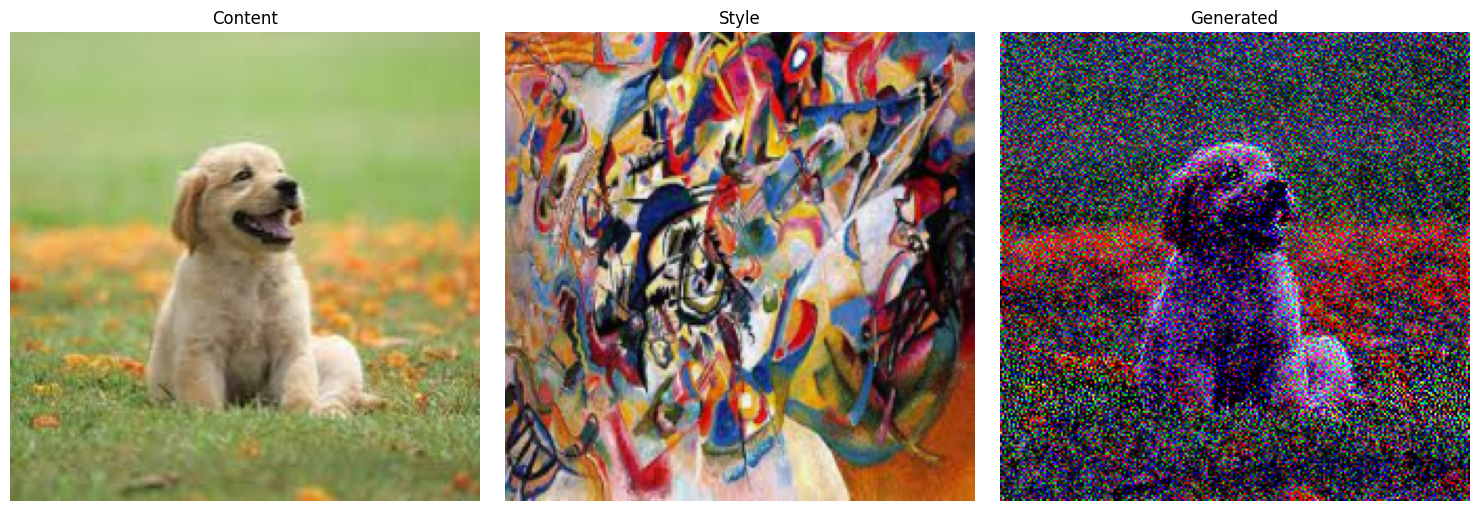

In [19]:
run(
    content_path="./assets/images/happy-boi.jpeg",
    style_path="./assets/styles/composition-VII.jpeg"
)